In [ ]:
pip install jax

In [ ]:
import jax
import jax.numpy as jnp
import numpy as np
import jax.lax as lax
import time
import matplotlib.pyplot as plt

# ===== Funciones base =====

def matmul_qkv_np(WQ, WK, WV, EI):
    return WQ @ EI, WK @ EI, WV @ EI

def attention_per_head_np(K, Q, V, l, ddh, b, h):
    lb = l * b
    E2 = np.zeros((K.shape[0], lb), dtype=K.dtype)
    for j in range(b):
        for i in range(h):
            indJ = j * l
            indI2 = i * ddh
            K_slice = K[indI2:indI2+ddh, indJ:indJ+l]
            Q_slice = Q[indI2:indI2+ddh, indJ:indJ+l]
            E1 = K_slice.T @ Q_slice
            V_slice = V[indI2:indI2+ddh, indJ:indJ+l]
            result = V_slice @ E1
            E2[indI2:indI2+ddh, indJ:indJ+l] = result
    return E2

def mha_output_np(WO, E2, EI):
    return EI + WO @ E2

def ffn_forward_np(W1, W2, AO):
    return AO + W2 @ (W1 @ AO)

# ===== Versiones JAX =====

def matmul_qkv_jax(WQ, WK, WV, EI):
    return WQ @ EI, WK @ EI, WV @ EI

def attention_per_head_jax(K, Q, V, l, ddh, b, h):
    lb = l*b
    E2 = jnp.zeros((K.shape[0], lb), dtype=K.dtype)

    def process_single_head(E2, idx):
        j, i = idx // h, idx % h
        indJ = j*l
        indI2 = i*ddh
        # E1 = (K^T) @ Q

        K_slice = lax.dynamic_slice(K, (indI2, indJ), (ddh, l))  # (rows, cols)
        Q_slice = lax.dynamic_slice(Q, (indI2, indJ), (ddh, l))
        E1 = K_slice.transpose() @ Q_slice
        # E2 = V @ E1
        V_slice = lax.dynamic_slice(V, (indI2, indJ), (ddh, l))
        result = V_slice @ E1
        E2 = lax.dynamic_update_slice(E2, result, (indI2, indJ))

        return E2, None

    E2_init = jnp.zeros((d, lb), dtype=jnp.float32)
    idxs = jnp.arange(b * h)
    E2, _ = lax.scan(process_single_head, E2_init, idxs)

    return E2

def mha_output_jax(WO, E2, EI):
    return EI + WO @ E2

def ffn_forward_jax(W1, W2, AO):
    return AO + W2 @ (W1 @ AO)

# ===== JIT =====
matmul_qkv_jit = jax.jit(matmul_qkv_jax)
attention_per_head_jit = jax.jit(attention_per_head_jax, static_argnums=(3, 4, 5, 6))

mha_output_jit = jax.jit(mha_output_jax)
ffn_forward_jit = jax.jit(ffn_forward_jax)

# ===== Parámetros =====
b, l, d, h = 8, 64, 512, 8
f = 4 * d
ddh = d // h
lb = b * l
key = jax.random.PRNGKey(0)
keys = jax.random.split(key, 7)

EI_jax = jax.random.uniform(keys[0], (d, lb), minval=-0.5, maxval=0.5)
WQ = jax.random.uniform(keys[1], (d, d), minval=-0.5, maxval=0.5)
WK = jax.random.uniform(keys[2], (d, d), minval=-0.5, maxval=0.5)
WV = jax.random.uniform(keys[3], (d, d), minval=-0.5, maxval=0.5)
WO = jax.random.uniform(keys[4], (d, d), minval=-0.5, maxval=0.5)
W1 = jax.random.uniform(keys[5], (f, d), minval=-0.5, maxval=0.5)
W2 = jax.random.uniform(keys[6], (d, f), minval=-0.5, maxval=0.5)

EI_np, WQ_np, WK_np, WV_np, WO_np, W1_np, W2_np = map(np.array, [EI_jax, WQ, WK, WV, WO, W1, W2])




In [1]:


# ===== Medición de tiempos con time.time()

results = {}

# NumPy
results["NumPy"] = {}

start = time.time()
Qn, Kn, Vn = matmul_qkv_np(WQ_np, WK_np, WV_np, EI_np)
end = time.time()
results["NumPy"]["matmul_qkv"] = end - start

start = time.time()
E2n = attention_per_head_np(Kn, Qn, Vn, l, ddh, b, h)
end = time.time()
results["NumPy"]["attention"] = end - start

start = time.time()
AOn = mha_output_np(WO_np, E2n, EI_np)
end = time.time()
results["NumPy"]["mha_output"] = end - start

start = time.time()
EOn = ffn_forward_np(W1_np, W2_np, AOn)
end = time.time()
results["NumPy"]["ffn"] = end - start

results["NumPy"]["total"] = sum(results["NumPy"].values())

# JAX sin JIT
results["JAX"] = {}

start = time.time()
Qj, Kj, Vj = matmul_qkv_jax(WQ, WK, WV, EI_jax)
end = time.time()
results["JAX"]["matmul_qkv"] = end - start

start = time.time()
E2j = attention_per_head_jax(Kj, Qj, Vj, l, ddh, b, h)
end = time.time()
results["JAX"]["attention"] = end - start

start = time.time()
AOj = mha_output_jax(WO, E2j, EI_jax)
end = time.time()
results["JAX"]["mha_output"] = end - start

start = time.time()
EOj = ffn_forward_jax(W1, W2, AOj)
end = time.time()
results["JAX"]["ffn"] = end - start

results["JAX"]["total"] = sum(results["JAX"].values())

# JAX con JIT
results["JAX-JIT"] = {}

# Compilación previa
results["JIT-COMP"] = {}
start=time.time()
matmul_qkv_compiled = matmul_qkv_jit.lower(WQ, WK, WV, EI_jax).compile()
end=time.time()
results["JIT-COMP"]["matmul_qkv"] = end - start

start = time.time()
attention_per_head_jit.lower(Kj, Qj, Vj, l, ddh, b, h).compile()
end = time.time()
results["JIT-COMP"]["attention"] = end - start

start = time.time()
mha_output_jit.lower(WO, E2j, EI_jax).compile()
end=time.time()
results["JIT-COMP"]["mha_output"] = end - start

start = time.time()
ffn_forward_jit.lower(W1, W2, AOj).compile()
end= time.time()
results["JIT-COMP"]["ffn"] = end - start

results["JIT-COMP"]["total"] = sum(results["JIT-COMP"].values())

start = time.time()
Qk, Kk, Vk = matmul_qkv_jit(WQ, WK, WV, EI_jax)
end = time.time()
results["JAX-JIT"]["matmul_qkv"] = end - start

start = time.time()
E2k = attention_per_head_jit(Kk, Qk, Vk, l, ddh, b, h)
end = time.time()
results["JAX-JIT"]["attention"] = end - start

start = time.time()
AOk = mha_output_jit(WO, E2k, EI_jax)
end = time.time()
results["JAX-JIT"]["mha_output"] = end - start

start = time.time()
EOk = ffn_forward_jit(W1, W2, AOk)
end = time.time()
results["JAX-JIT"]["ffn"] = end - start

results["JAX-JIT"]["total"] = sum(results["JAX-JIT"].values())



NameError: name 'time' is not defined

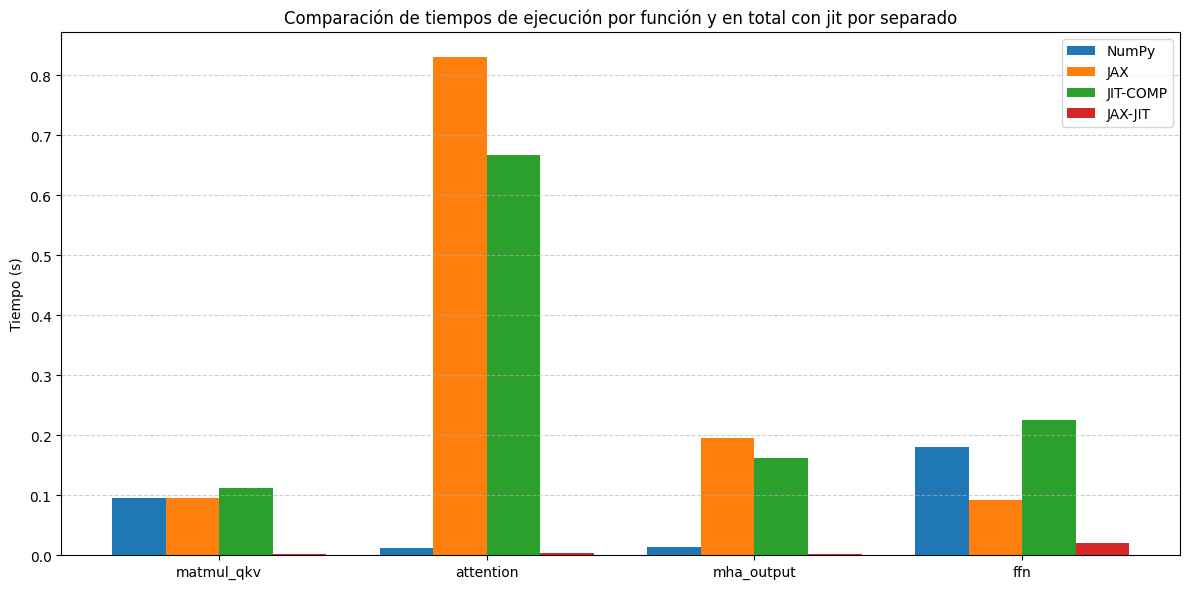

In [ ]:
# ===== Gráfico comparativo =====
labels = ["matmul_qkv", "attention", "mha_output", "ffn"]
x = np.arange(len(labels))
width = 0.20  # Reducí el ancho para que quepan todas las barras

fig, ax = plt.subplots(figsize=(12, 6))

# Barras con posiciones ajustadas
ax.bar(x - 1.5*width, [results["NumPy"][l] for l in labels], width, label='NumPy')
ax.bar(x - 0.5*width, [results["JAX"][l] for l in labels], width, label='JAX')
ax.bar(x + 0.5*width, [results["JIT-COMP"][l] for l in labels], width, label='JIT-COMP')
ax.bar(x + 1.5*width, [results["JAX-JIT"][l] for l in labels], width, label='JAX-JIT')

ax.set_ylabel('Tiempo (s)')
ax.set_title('Comparación de tiempos de ejecución por función y en total con jit por separado')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()

# Mejoras adicionales opcionales:
ax.grid(True, axis='y', linestyle='--', alpha=0.6)
plt.tight_layout()

# Si hay mucha diferencia de escala, considera escala logarítmica
# ax.set_yscale('log')

plt.show()

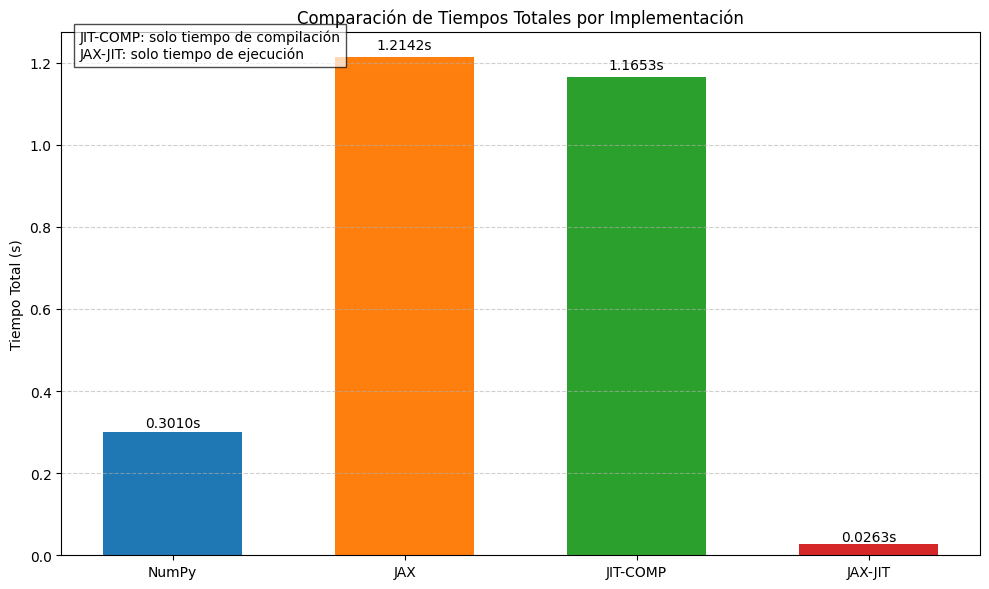

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# ===== Gráfico de tiempos totales =====
labels = ["NumPy", "JAX", "JIT-COMP", "JAX-JIT"]
x = np.arange(len(labels))
width = 0.6  # Ancho más grande para una sola barra por implementación

fig, ax = plt.subplots(figsize=(10, 6))

# Barras con los tiempos totales
ax.bar(x, [results[label]["total"] for label in labels], width,
       color=['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728'])

# Añadir valores encima de las barras
for i, label in enumerate(labels):
    height = results[label]["total"]
    ax.text(i, height + 0.01 * height, f'{height:.4f}s',
            ha='center', va='bottom')

ax.set_ylabel('Tiempo Total (s)')
ax.set_title('Comparación de Tiempos Totales por Implementación')
ax.set_xticks(x)
ax.set_xticklabels(labels)

# Mejoras adicionales
ax.grid(True, axis='y', linestyle='--', alpha=0.6)
plt.tight_layout()

# Opcional: escala logarítmica si hay mucha variación
# ax.set_yscale('log')

# Añadir leyenda explicativa para JIT-COMP
plt.text(0.02, 0.95, 'JIT-COMP: solo tiempo de compilación\nJAX-JIT: solo tiempo de ejecución',
         transform=ax.transAxes, fontsize=10,
         bbox=dict(facecolor='white', alpha=0.7))

plt.show()

In [ ]:
matmul_qkv_compiled.cost_analysis()

{'bytes accessedout{}': 3145752.0,
 'bytes accessed1{}': 3145728.0,
 'utilization0{}': 4.0,
 'bytes accessed0{}': 3145728.0,
 'flops': 805306368.0,
 'utilization1{}': 4.0,
 'bytes accessed': 9437208.0,
 'utilization2{}': 1.0}